## A SST (sea surface temperature) forecasting problem

In this dataset, twelve different quantities (such as Age, d180, d180N, L*, SST, Alkane, Alkanol, Sediment, Red, Green, Blue, and Grey) are recorded every sedimentary layer deposited, over millions of years. The original data goes back to 4,260 ka in deposited sedimentary data. 

This dataset is perfect for learning to work with numerical timeseries. We will use it to build a model that takes as input some data from the recent past (a few thousand years worth of data points) and predicts the sea surface temperature for days and years in the future.

In [32]:
# Common imports and toolboxes needed for workflow
# System imports
import os
import sys

# Mathematical imports
import numpy as np
import math

# To make this notebook's output stable across runs
np.random.seed(42)


# Visualization imports
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import image as img
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rcParams['figure.figsize'] = (20,10)

from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import ColumnDataSource, ColorBar
from bokeh.palettes import Spectral6
from bokeh.transform import linear_cmap
from bokeh.plotting import figure
output_notebook()

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGE_ID = "Final_Images"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "Images", IMAGE_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Loading BokehJS ...

In [3]:
import pandas as pd

lstar = pd.read_csv('./Drill_Sites/lstar.csv')

lstar.describe()

,Age (ka),1313 L* Depth (amcd),1313 L*,1313 L* Norm Detrend
count,4001.000000,4001.000000,4001.000000,4.001000e+03
mean,2125.552473,100.000000,74.030992,-8.747813e-07
std,1239.203776,57.756677,7.829917,1.000001e+00
min,0.000000,0.000000,51.260000,-3.257200e+00
25%,1050.318000,50.000000,68.620000,-5.986000e-01
50%,2117.417000,100.000000,75.820000,1.323000e-01
75%,3205.075000,150.000000,80.300000,6.195000e-01
max,4261.442000,200.000000,87.010000,3.324200e+00


In [4]:
lro4 = pd.read_csv('./Drill_Sites/LRO4.csv')

lro4.describe()

,Age (ka),LRO4 Depth (amcd),LRO4 d18O,LRO4 d18O Norm Detrend
count,1903.000000,0.0,1903.000000,1903.000000
mean,1534.177614,NaN,3.807486,0.000001
std,1176.593587,NaN,0.498841,1.000000
min,0.000000,NaN,2.775000,-2.877500
25%,475.500000,NaN,3.426000,-0.660350
50%,1302.000000,NaN,3.783000,0.020600
75%,2441.500000,NaN,4.170000,0.579700
max,4260.000000,NaN,5.085000,3.380200


In [5]:
alkane = pd.read_csv('./Drill_Sites/alkane.csv')

alkane.describe()

,Age (ka),Alkane Depth (amcd),Alkanes (ng/g)
count,2514.000000,2514.000000,2514.000000
mean,1020.640477,48.514113,96.159845
std,852.342315,40.121076,85.584919
min,0.000000,0.170000,0.790000
25%,477.412500,21.805000,31.095000
50%,700.255000,34.340000,67.140000
75%,1276.352500,60.220000,138.215000
max,3474.970000,161.000000,566.620000


In [6]:
alkanol = pd.read_csv('./Drill_Sites/alkanol.csv')

alkanol.describe()

,Age (ka),Alkanol Depth (amcd),Alkanol (ng/g)
count,457.000000,457.000000,457.000000
mean,1474.179540,69.827571,57.787746
std,988.982802,46.498779,61.118888
min,6.910000,0.250000,0.000000
25%,610.770000,30.200000,13.000000
50%,1344.940000,63.300000,34.000000
75%,2328.430000,110.450000,81.000000
max,3462.020000,160.400000,345.000000


In [7]:
color = pd.read_csv('./Drill_Sites/color.csv')

color.describe()

,Age (ka),Red Norm,Green Norm,Blue Norm,Grey Norm
count,1903.000000,1903.000000,1903.000000,1903.000000,1903.000000
mean,1534.177614,0.009124,0.007043,0.006127,0.007615
std,1176.593587,0.496331,0.491195,0.490241,0.492846
min,0.000000,-3.238145,-3.037077,-2.752926,-3.075705
25%,475.500000,0.000000,0.000000,0.000000,0.000000
50%,1302.000000,0.000000,0.000000,0.000000,0.000000
75%,2441.500000,0.000000,0.000000,0.000000,0.000000
max,4260.000000,1.415121,1.448314,1.586844,1.412118


In [8]:
sst = pd.read_csv('./Drill_Sites/sst.csv')

sst.describe()

,Age (ka),SST Depth (amcd),SST (°C)
count,2455.000000,2455.000000,2455.000000
mean,1061.312485,50.434118,16.148232
std,858.714723,40.395769,2.556232
min,0.000000,0.170000,7.650000
25%,502.070000,23.290000,14.465000
50%,718.100000,35.290000,16.260000
75%,1371.260000,65.000000,17.830000
max,3474.970000,161.000000,23.320000


In [37]:
Red = color['Red Norm'].copy()
Blue = color['Blue Norm'].copy()
Green = color['Green Norm'].copy()
Grey = color['Grey Norm'].copy()
LStar = lstar['1313 L* Norm Detrend']
d18O = lro4['LRO4 d18O Norm Detrend']
SST = sst[2]
Alkane = alkane[2]
Alkanol = alkanol[2]
Age = lro4['Age (ka)']

In [58]:
data = pd.read_csv('./Prediction/Final.csv')
data.head()

,Age,d180,d180N,L*,SST,Alkane,Alkanol,Sediment,Red,Green,Blue,Grey
0,0,3.228,1.161664,-2.175118,0.545283,-0.109360,-2.748250,2.729549,-0.888887,-1.393378,-1.529918,-1.261629
1,1,3.228,1.161664,-2.252229,0.152172,-0.132815,0.741463,2.729549,-0.524649,-1.095312,-1.330603,-0.954727
2,2,3.179,1.259892,-2.269439,-0.528866,0.155576,3.962484,2.729549,-0.312894,-0.918423,-1.228388,-0.773885
3,3,3.286,1.045395,-2.469090,-1.572280,0.638307,6.194622,2.729549,-0.375493,-1.005194,-1.279251,-0.850825
4,4,3.295,1.027353,-2.375546,-2.041553,1.278914,6.465403,2.729549,-0.379937,-0.992837,-1.268917,-0.844385


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14f928290>,
      dtype=object)

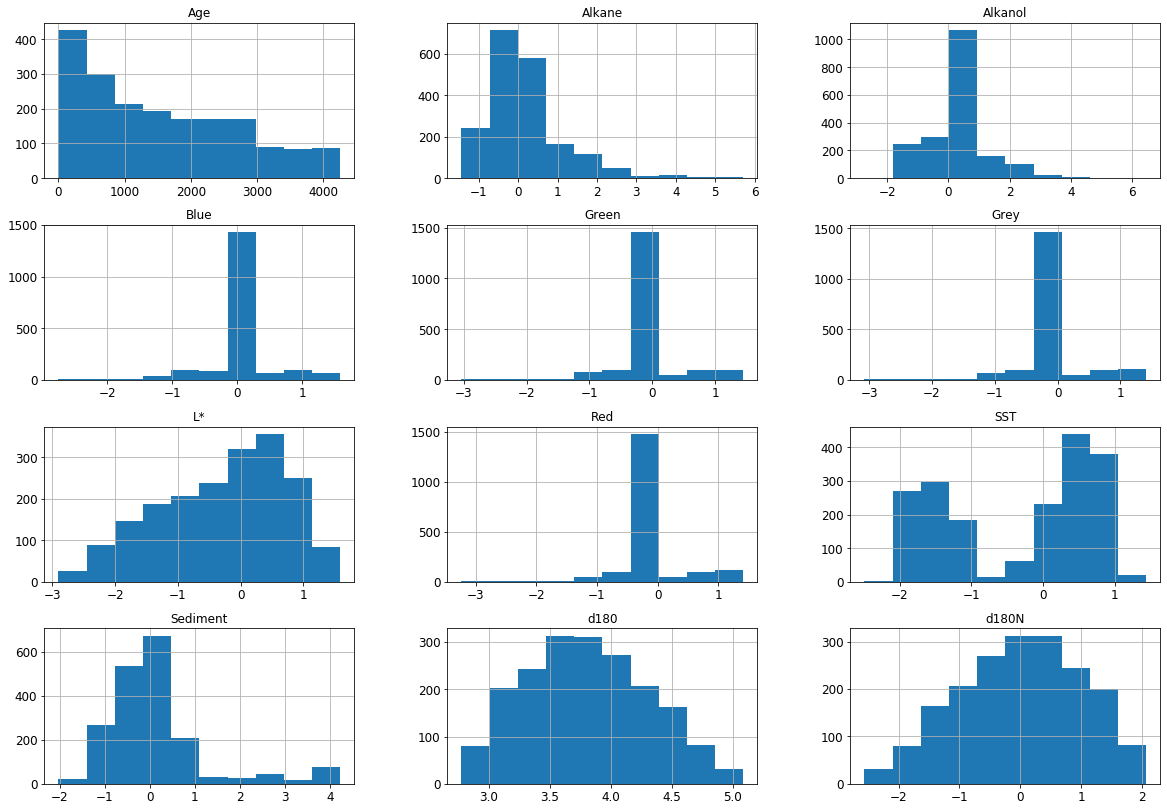

In [42]:
plt.rcParams['figure.figsize'] = (20,14)
data.hist()

In [44]:
x = range(0, 4001)
y = data['L*']
z = data['d180N']
z1 = data['Alkane']
z2 = data['Alkanol']
z3 = data['SST']
z4 = data['Red']


p = figure(title='Sequential Ages of Features in (ka)', plot_width=980, plot_height=800)
r = p.line(x, y, color='magenta', line_width=0.5,legend_label='L*')
r1 = p.line(x, z, color='purple', line_width=0.5,legend_label='LRO4')
r2 = p.line(x, z1, color='black', line_width=0.5,legend_label='Alkane')
r3 = p.line(x, z2, color='pink', line_width=0.5,legend_label='Alkanol')
r4 = p.line(x, z3, color='orange', line_width=0.5,legend_label='SST')
r5 = p.line(x, z4, color='brown', line_width=0.5,legend_label='Color')


p.xaxis.axis_label = 'Geologic Time (ka)'
p.yaxis.axis_label = 'Age Sequences through Time (ka)'
p.legend.location = 'top_right'
show(p)

In [59]:
data.isna().sum()

Age            0
d180           0
d180N          0
L*             0
SST          158
Alkane       158
Alkanol      161
Sediment     158
Red         1395
Green       1395
Blue        1395
Grey        1395
dtype: int64

In [62]:
data.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14fbad090>,
      dtype=object)

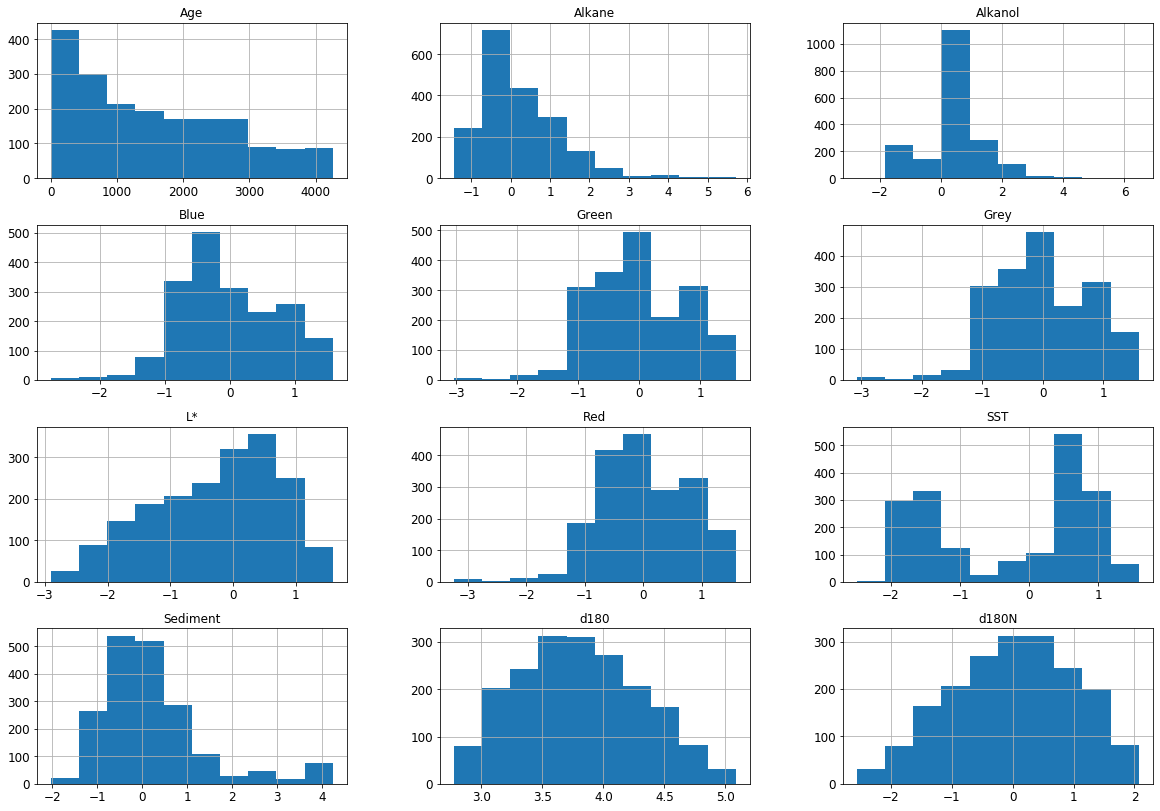

In [63]:
plt.rcParams['figure.figsize'] = (20,14)
data.hist()

In [64]:
data.isna().sum()

Age         0
d180        0
d180N       0
L*          0
SST         0
Alkane      0
Alkanol     0
Sediment    0
Red         0
Green       0
Blue        0
Grey        0
dtype: int64

In [66]:
x = range(0, 4001)
y = data['L*']
z = data['d180N']
z1 = data['Alkane']
z2 = data['Alkanol']
z3 = data['SST']
z4 = data['Red']
z5 = data['Green']
z6 = data['Blue']
z7 = data['Grey']


p = figure(title='Sequential Ages of Features in (ka)', plot_width=980, plot_height=800)
r = p.line(x, y, color='magenta', line_width=0.5,legend_label='L*')
r1 = p.line(x, z, color='purple', line_width=0.5,legend_label='LRO4')
r2 = p.line(x, z1, color='black', line_width=0.5,legend_label='Alkane')
r3 = p.line(x, z2, color='pink', line_width=0.5,legend_label='Alkanol')
r4 = p.line(x, z3, color='orange', line_width=0.5,legend_label='SST')
r5 = p.line(x, z4, color='red', line_width=0.5,legend_label='Red')
r6 = p.line(x, z, color='green', line_width=0.5,legend_label='Green')
r7 = p.line(x, z, color='blue', line_width=0.5,legend_label='Blue')
r8 = p.line(x, z, color='grey', line_width=0.5,legend_label='Grey')

p.xaxis.axis_label = 'Geologic Time (ka)'
p.yaxis.axis_label = 'Age Sequences through Time (ka)'
p.legend.location = 'top_right'
show(p)

In [14]:
from numpy import genfromtxt
float_data = genfromtxt('Final_clean.csv', skip_header=1, delimiter=',', dtype='<f8')
float_data

array([[ 0.00000000e+00,  3.22800000e+00,  1.16166443e+00, ...,
        -1.39337840e+00, -1.52991776e+00, -1.26162936e+00],
       [ 1.00000000e+00,  3.22800000e+00,  1.16166443e+00, ...,
        -1.09531238e+00, -1.33060263e+00, -9.54727189e-01],
       [ 2.00000000e+00,  3.17900000e+00,  1.25989208e+00, ...,
        -9.18423283e-01, -1.22838834e+00, -7.73884956e-01],
       ...,
       [ 4.25000000e+03,  3.00000000e+00,  1.61872371e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.25500000e+03,  3.12900000e+00,  1.36012438e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.26000000e+03,  2.91900000e+00,  1.78110004e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [15]:
import tensorflow as tf
t = tf.constant(float_data, dtype=tf.float32) # data as tensors
s = tf.io.serialize_tensor(t) # serialized tensors
s

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\x08\x01\x12\t\x12\x03\x08\xef\x0e\x12\x02\x08\x0c"\xd0\xc9\x05\x00\x00\x00\x00\x8d\x97N@l\xb1\x94?"5\x0b\xc0\xb1\x97\x0b?\x02\xf8\xdf\xbdU\xe3/\xc0\xee\xb0.@\x13\x8ec\xbf9Z\xb2\xbfX\xd4\xc3\xbf\x12}\xa1\xbf\x00\x00\x80?\x8d\x97N@l\xb1\x94?\x85$\x10\xc0\xfa\xd2\x1b>\xb8\x00\x08\xbe\x83\xd0=?\xee\xb0.@eO\x06\xbf23\x8c\xbf0Q\xaa\xbf\x00it\xbf\x00\x00\x00@\xbctK@%D\xa1?|>\x11\xc0\xc5c\x07\xbfmO\x1f>U\x99}@\xee\xb0.@\xa53\xa0\xbe\xca\x1dk\xbf\xd4;\x9d\xbfS\x1dF\xbf\x00\x00@@\xd3MR@\x81\xcf\x85?\x92\x05\x1e\xc0|@\xc9\xbf\x18h#?X:\xc6@\xee\xb0.@\xa4@\xc0\xbe0\xaa\x80\xbf\x81\xbe\xa3\xbf\xa9\xcfY\xbf\x00\x00\x80@H\xe1R@O\x80\x83?\xf4\x08\x18\xc0\xd0\xa8\x02\xc0x\xb3\xa3?\x95\xe4\xce@\xee\xb0.@&\x87\xc2\xbe\x88*~\xbf\xdek\xa2\xbf\xa0)X\xbf\x00\x00\xa0@`\xe5P@\xa5t\x8b?\xe3\xd9\x16\xc0\xab\x1b\x16\xc0\xf5\r\x0b@\x02\xd8\xb4@\xee\xb0.@\x8f\xea\xcd\xbe\x16\xd6\x80\xbf}\xe8\xa3\xbf\xeb.\\\xbf\x00\x00\xc0@\xdfOU@O\x80s?7\xaf\x0e\xc0\x03\x9f\x1f\xc0T

In [16]:
parsed_tensors = tf.io.parse_tensor(s, out_type=tf.float32)
parsed_tensors

<tf.Tensor: id=2, shape=(1903, 12), dtype=float32, numpy=
array([[ 0.0000000e+00,  3.2279999e+00,  1.1616645e+00, ...,
        -1.3933784e+00, -1.5299177e+00, -1.2616293e+00],
       [ 1.0000000e+00,  3.2279999e+00,  1.1616645e+00, ...,
        -1.0953124e+00, -1.3306026e+00, -9.5472717e-01],
       [ 2.0000000e+00,  3.1789999e+00,  1.2598921e+00, ...,
        -9.1842330e-01, -1.2283883e+00, -7.7388495e-01],
       ...,
       [ 4.2500000e+03,  3.0000000e+00,  1.6187238e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 4.2550000e+03,  3.1289999e+00,  1.3601243e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 4.2600000e+03,  2.9189999e+00,  1.7811000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)>

In [17]:
parsed_tensors.shape

TensorShape([1903, 12])

In [18]:
float_data.shape

(1903, 12)

In [19]:
age = float_data[:, 0] # age in (ka)
d18O = float_data[:, 1] # oxygen isotope ratio 
d18ON = float_data[:, 2] # oxygen isotope ratio normarlized
l_star = float_data[:, 3] # L* values
sst = float_data[:, 4] # sea surface temperature 
alkane = float_data[:, 5] # methane values
alkanol = float_data[:, 6] # ethanol values
sediment = float_data[:, 7] # what is this
red = float_data[:, 8] # red pixel values
green = float_data[:, 9] # green pixel values 
blue = float_data[:, 10] # blue pixel values
grey = float_data[:, 11] # grey pixel values

In [23]:
x = age
# y = sst
# z = d18O
z1 = l_star
# z2 = alkane
# z3 = alkanol
# z4 = sediment
z5 = red
z6 = green
z7 = blue
z8 = grey

p = figure(title='Sequential Variations of Features in Deep Time', plot_width=980, plot_height=800)
# r = p.line(x, y, color='magenta', line_width=0.5,legend_label='SST')
# r1 = p.line(x, z, color='purple', line_width=0.5,legend_label='d18O')
r2 = p.line(x, z1, color='black', line_width=0.5,legend_label='L*')
# r3 = p.line(x, z2, color='pink', line_width=0.5,legend_label='Alkane')
# r4 = p.line(x, z3, color='orange', line_width=0.5,legend_label='Alkanol')
# r5 = p.line(x, z4, color='brown', line_width=0.5,legend_label='Sediment')
r6 = p.line(x, z5, color='red', line_width=0.5,legend_label='Red')
r7 = p.line(x, z6, color='green', line_width=0.5,legend_label='Green')
r8 = p.line(x, z7, color='blue', line_width=0.5,legend_label='Blue')
r9 = p.line(x, z8, color='gray', line_width=0.5,legend_label='Gray')


p.xaxis.axis_label = 'Geologic Time (ka)'
p.yaxis.axis_label = 'Sequences through Time (ka)'
p.legend.location = 'bottom_right'
show(p)

Saving figure color_variations


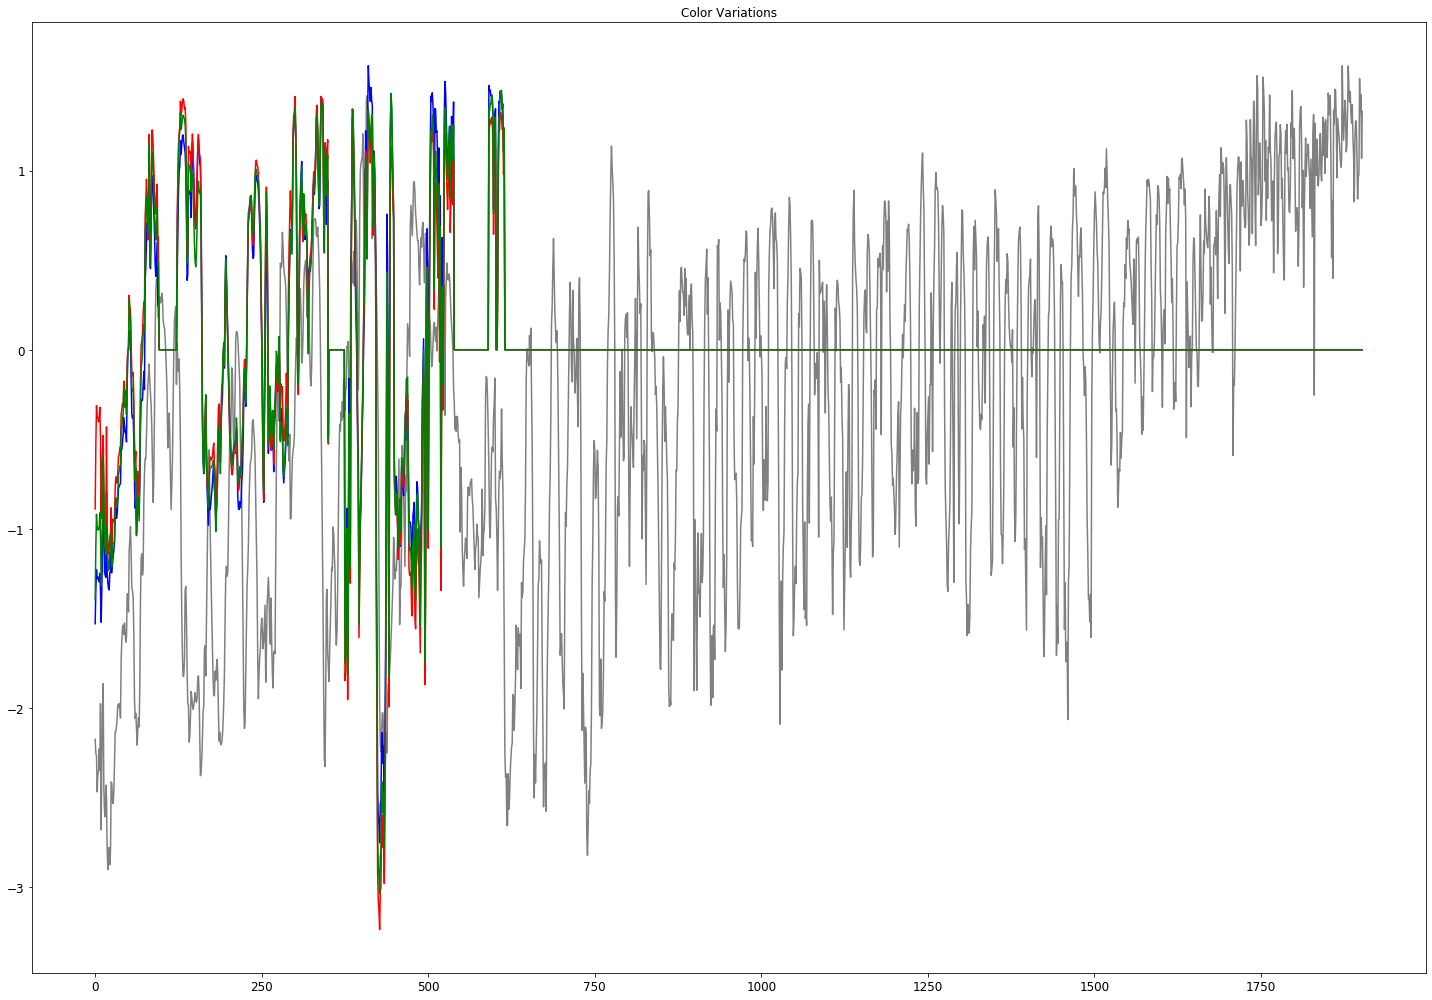

In [50]:
plt.plot(data['L*'], 'grey', label='L*')
plt.plot(data['Blue'], 'b', label='Blue')
plt.plot(data['Red'], 'r', label='Red')
plt.plot(data['Green'], 'g', label='Green')
plt.title('Color Variations')

save_fig('color_variations')

## Preparing the data


The exact formulation of our problem will be the following: given data going as far back as `lookback` timesteps (a timestep is 10 minutes) 
and sampled every `steps` timesteps, can we predict the temperature in `delay` timesteps?

We will use the following parameter values:

* `lookback = 10`, i.e. our observations will go back 5 ages of geologic time.
* `steps = 1`, i.e. our observations will be sampled at one data point per age.
* `delay = 5`, i.e. our targets will be days (ka) in the future.

To get started, we need to do two things:

* Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so we don't need to do any 
vectorization. However each timeseries in the data is on a different scale (e.g. temperature is typically between -20 and +30, but 
color, measured in RGB, is around 0-255). So we will normalize each timeseries independently so that they all take small values on a 
similar scale.
* Write a Python generator that takes our current array of float data and yields batches of data from the recent past, alongside with a 
target temperature in the future. Since the samples in our dataset are highly redundant (e.g. sample `N` and sample `N + 1` will have most 
of their timesteps in common), it would be very wasteful to explicitly allocate every sample. Instead, we will generate the samples on the 
fly using the original data.

We preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. We plan on using the first 
802 timesteps as training data, so we compute the mean and standard deviation only on this fraction of the data:


Now here is the data generator that we will use. It yields a tuple `(samples, targets)` where `samples` is one batch of input data and 
`targets` is the corresponding array of target temperatures. It takes the following arguments:

* `data`: The original array of floating point data, which we just normalized in the code snippet above.
* `lookback`: How many timesteps back should our input data go.
* `delay`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another one for testing.
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it 1 in order to draw one data point every age recorded.

In [183]:
    
mean = float_data[:802].mean(axis=0) # means for first 1000 ka 
float_data -= mean
std = float_data[:802].std(axis=0) # std.devs for first 1000 ka
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=20, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 10
step = 1
delay = 5
batch_size = 20

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0, # 0 ka
                      max_index=802, # 1000 ka
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=803, # 1001 ka
                    max_index=1252, # 2000 ka
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=1253, # 2001 ka
                     max_index=None, # 4260 ka
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (1252 - 803 - lookback)

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 1253 - lookback)


Now let's use our abstract generator function to instantiate three generators, one for training, one for validation and one for testing. 
Each will look at different temporal segments of the original data: the training generator looks at the first 802 timesteps, the 
validation generator looks at the following 449, and the test generator looks at the remainder.

## A common sense, non-machine learning baseline


Before we start leveraging black-box deep learning models to solve our temperature prediction problem, let's try out a simple common-sense 
approach. It will serve as a sanity check, and it will establish a baseline that we will have to beat in order to demonstrate the 
usefulness of more advanced machine learning models. Such common-sense baselines can be very useful when approaching a new problem for 
which there is no known solution (yet). A classic example is that of unbalanced classification tasks, where some classes can be much more 
common than others. If your dataset contains 90% of instances of class A and 10% of instances of class B, then a common sense approach to 
the classification task would be to always predict "A" when presented with a new sample. Such a classifier would be 90% accurate overall, 
and any learning-based approach should therefore beat this 90% score in order to demonstrate usefulness. Sometimes such elementary 
baseline can prove surprisingly hard to beat.

In our case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the 
temperatures today) as well as periodical with a daily period. Thus a common sense approach would be to always predict that the temperature 
24 hours from now will be equal to the temperature right now. Let's evaluate this approach, using the Mean Absolute Error metric (MAE). 
Mean Absolute Error is simply equal to:

In [55]:
# np.mean(np.abs(preds - targets))

In [72]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.7411677051222907


It yields a MAE of 0.74. Since our temperature data has been normalized to be centered on 0 and have a standard deviation of one, this 
number is not immediately interpretable. It translates to an average absolute error of `0.74 * temperature_std` degrees Celsius, i.e. 
2.57˚C. That's a fairly large average absolute error -- now the game is to leverage our knowledge of deep learning to do better. 

In [73]:
celsius_mae = 0.73601 * std[1]
celsius_mae

0.73601

## A basic machine learning approach

In the same way that it is useful to establish a common sense baseline before trying machine learning approaches, it is useful to try 
simple and cheap machine learning models (such as small densely-connected networks) before looking into complicated and computationally 
expensive models such as RNNs. This is the best way to make sure that any further complexity we throw at the problem later on is legitimate 
and delivers real benefits.

Here is a simply fully-connected model in which we start by flattening the data, then run it through two `Dense` layers. Note the lack of 
activation function on the last `Dense` layer, which is typical for a regression problem. We use MAE as the loss. Since we are evaluating 
on the exact same data and with the exact same metric as with our common sense approach, the results will be directly comparable.

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, 
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 7s 13ms/step - loss: 0.4691 - val_loss: 0.5332
Epoch 2/20
500/500 [==============================] - 6s 13ms/step - loss: 0.3589 - val_loss: 0.7511
Epoch 3/20
500/500 [==============================] - 6s 12ms/step - loss: 0.3261 - val_loss: 0.7181
Epoch 4/20
500/500 [==============================] - 6s 13ms/step - loss: 0.3048 - val_loss: 0.6297
Epoch 5/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2842 - val_loss: 0.6303
Epoch 6/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2635 - val_loss: 0.6533
Epoch 7/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2522 - val_loss: 0.7040
Epoch 8/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2406 - val_loss: 0.6323
Epoch 9/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2316 - val_loss: 0.7376
Epoch 10/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2213 - val_lo

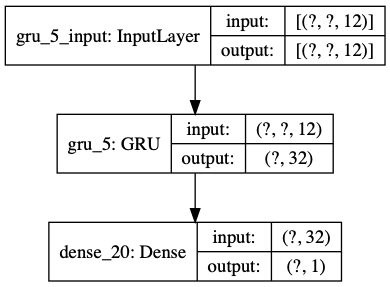

In [176]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='basic_model.png')

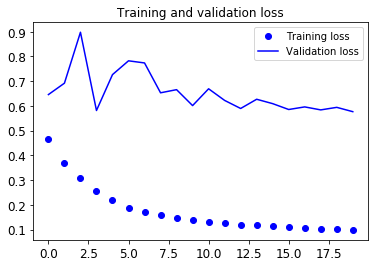

In [100]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Some of our validation losses get close to the no-learning baseline, but not very reliably. This goes to show the merit of having had this baseline in the first place: it turns out not to be so easy to outperform. Our 
common sense contains already a lot of valuable information that a machine learning model does not have access to.

You may ask, if there exists a simple, well-performing model to go from the data to the targets (our common sense baseline), why doesn't 
the model we are training find it and improve on it? Simply put: because this simple solution is not what our training setup is looking 
for. The space of models in which we are searching for a solution, i.e. our hypothesis space, is the space of all possible 2-layer networks 
with the configuration that we defined. These networks are already fairly complicated. When looking for a solution with a space of 
complicated models, the simple well-performing baseline might be unlearnable, even if it's technically part of the hypothesis space. That 
is a pretty significant limitation of machine learning in general: unless the learning algorithm is hard-coded to look for a specific kind 
of simple model, parameter learning can sometimes fail to find a simple solution to a simple problem.

## A first recurrent baseline


Our first fully-connected approach didn't do so well, but that doesn't mean machine learning is not applicable to our problem. The approach 
above consisted in first flattening the timeseries, which removed the notion of time from the input data. Let us instead look at our data 
as what it is: a sequence, where causality and order matter. We will try a recurrent sequence processing model -- it should be the perfect 
fit for such sequence data, precisely because it does exploit the temporal ordering of data points, unlike our first approach.

Instead of the `LSTM` layer introduced in the previous section, we will use the `GRU` layer, developed by Cho et al. in 2014. `GRU` layers 
(which stands for "gated recurrent unit") work by leveraging the same principle as LSTM, but they are somewhat streamlined and thus cheaper 
to run, albeit they may not have quite as much representational power as LSTM. This trade-off between computational expensiveness and 
representational power is seen everywhere in machine learning.

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 23s 45ms/step - loss: 0.4641 - val_loss: 0.6458
Epoch 2/20
500/500 [==============================] - 22s 43ms/step - loss: 0.3703 - val_loss: 0.6919
Epoch 3/20
500/500 [==============================] - 23s 46ms/step - loss: 0.3064 - val_loss: 0.8979
Epoch 4/20
500/500 [==============================] - 23s 46ms/step - loss: 0.2569 - val_loss: 0.5813
Epoch 5/20
500/500 [==============================] - 23s 45ms/step - loss: 0.2185 - val_loss: 0.7265
Epoch 6/20
500/500 [==============================] - 22s 43ms/step - loss: 0.1880 - val_loss: 0.7823
Epoch 7/20
500/500 [==============================] - 23s 46ms/step - loss: 0.1723 - val_loss: 0.7737
Epoch 8/20
500/500 [==============================] - 24s 47ms/step - loss: 0.1582 - val_loss: 0.6529
Epoch 9/20
500/500 [==============================] - 22s 45ms/step - loss: 0.1475 - val_loss: 0.6656
Epoch 10/20
500/500 [==============================] - 22s 45ms/step - loss: 0.137

In [ ]:
plot_model(model, show_shapes=True, to_file='gru_dense_model.png')

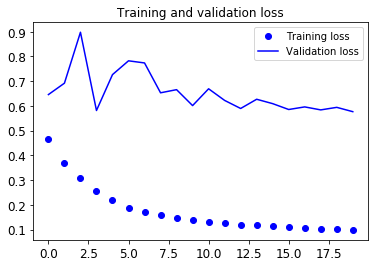

In [101]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Much better! We are able to significantly beat the common sense baseline, such demonstrating the value of machine learning here, as well as 
the superiority of recurrent networks compared to sequence-flattening dense networks on this type of task.

Our new validation MAE of ~0.0984 (before we start significantly overfitting) translates to a mean absolute error of 2.35˚C after 
de-normalization. That's a solid gain on our initial error of 2.57˚C, but we probably still have a bit of margin for improvement.

## Using recurrent dropout to fight overfitting


It is evident from our training and validation curves that our model is overfitting: the training and validation losses start diverging 
considerably after a few epochs. You are already familiar with a classic technique for fighting this phenomenon: dropout, consisting in 
randomly zeroing-out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. 
How to correctly apply dropout in recurrent networks, however, is not a trivial question. It has long been known that applying dropout 
before a recurrent layer hinders learning rather than helping with regularization. In 2015, Yarin Gal, as part of his Ph.D. thesis on 
Bayesian deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of 
dropped units) should be applied at every timestep, instead of a dropout mask that would vary randomly from timestep to timestep. What's 
more: in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant 
dropout mask should be applied to the inner recurrent activations of the layer (a "recurrent" dropout mask). Using the same dropout mask at 
every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would instead 
disrupt this error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers. Every recurrent layer in Keras 
has two dropout-related arguments: `dropout`, a float specifying the dropout rate for input units of the layer, and `recurrent_dropout`, 
specifying the dropout rate of the recurrent units. Let's add dropout and recurrent dropout to our GRU layer and see how it impacts 
overfitting. Because networks being regularized with dropout always take longer to fully converge, we train our network for twice as many 
epochs.

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 16s 31ms/step - loss: 0.6478 - val_loss: 0.5369
Epoch 2/40
500/500 [==============================] - 16s 32ms/step - loss: 0.5985 - val_loss: 0.6485
Epoch 3/40
500/500 [==============================] - 16s 32ms/step - loss: 0.5751 - val_loss: 0.5953
Epoch 4/40
500/500 [==============================] - 16s 33ms/step - loss: 0.5404 - val_loss: 0.5465
Epoch 5/40
500/500 [==============================] - 17s 33ms/step - loss: 0.5157 - val_loss: 0.5834
Epoch 6/40
500/500 [==============================] - 16s 33ms/step - loss: 0.5095 - val_loss: 0.6218
Epoch 7/40
500/500 [==============================] - 16s 32ms/step - loss: 0.4909 - val_loss: 0.6149
Epoch 8/40
500/500 [==============================] - 16s 32ms/step - loss: 0.4807 - val_loss: 0.6206
Epoch 9/40
500/500 [==============================] - 16s 32ms/step - loss: 0.4588 - val_loss: 0.6379
Epoch 10/40
500/500 [==============================] - 16s 31ms/step - loss: 0.451

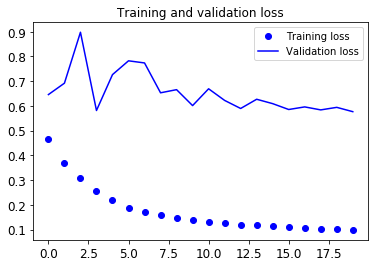

In [102]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Stacking recurrent layers

Since we are no longer overfitting yet we seem to have hit a performance bottleneck, we should start considering increasing the capacity of 
our network. If you remember our description of the "universal machine learning workflow": it is a generally a good idea to increase the 
capacity of your network until overfitting becomes your primary obstacle (assuming that you are already taking basic steps to mitigate 
overfitting, such as using dropout). As long as you are not overfitting too badly, then you are likely under-capacity.

Increasing network capacity is typically done by increasing the number of units in the layers, or adding more layers. Recurrent layer 
stacking is a classic way to build more powerful recurrent networks: for instance, what currently powers the Google translate algorithm is 
a stack of seven large LSTM layers -- that's huge.

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) 
rather than their output at the last timestep. This is done by specifying `return_sequences=True`: 

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 27s 54ms/step - loss: 0.6310 - val_loss: 0.5976
Epoch 2/40
500/500 [==============================] - 27s 54ms/step - loss: 0.5705 - val_loss: 0.6277
Epoch 3/40
500/500 [==============================] - 27s 54ms/step - loss: 0.5262 - val_loss: 0.8046
Epoch 4/40
500/500 [==============================] - 27s 54ms/step - loss: 0.4938 - val_loss: 0.5768
Epoch 5/40
500/500 [==============================] - 27s 54ms/step - loss: 0.4738 - val_loss: 0.6359
Epoch 6/40
500/500 [==============================] - 27s 54ms/step - loss: 0.4503 - val_loss: 0.5749
Epoch 7/40
500/500 [==============================] - 29s 57ms/step - loss: 0.4306 - val_loss: 0.6154
Epoch 8/40
500/500 [==============================] - 27s 54ms/step - loss: 0.4158 - val_loss: 0.5633
Epoch 9/40
500/500 [==============================] - 27s 54ms/step - loss: 0.4177 - val_loss: 0.6388
Epoch 10/40
500/500 [==============================] - 27s 54ms/step - loss: 0.401

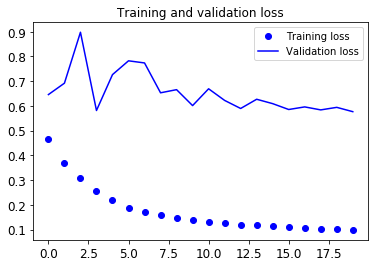

In [103]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [187]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = tf.keras.Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


InvalidArgumentError: Computed output size would be negative: -2 [input_size: 2, effective_filter_size: 5, stride: 1] [Op:Conv2D] name: sequential_20/conv1d_34/conv1d/

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()